In [32]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

from utils.oversampling import fit_resample
from utils.data_processer import *

In [33]:
data = pd.read_csv("../creditcard_2021.csv")
print(f"Number of samples: {len(data)}")
print(f"Number of fraudolent transaction: {(data['Class'] == 1).sum()}")
print(f"Ratio of fraudolent transaction: {data['Class'].mean()}")

Number of samples: 284807
Number of fraudolent transaction: 492
Ratio of fraudolent transaction: 0.001727485630620034


# Logistic Regression

$$z = \alpha_0 + \alpha_1X_1 + \alpha_2X_2 + ... + \alpha_nX_n$$

$$y_{pred} = sigmoid(q) = \frac{1}{1 + e^{-q}}$$

In [34]:
class LogisticRegression:
    def __init__(self, num_features=None):
        self.num_features = num_features

    def initialize_parameters(self, num_features=None):
        """
            Sets the parameters (weights and bias) for the logistic regression given the number of features

            Returns the parameters of the logistic regression given the number of
            neurons of its layers, namely it sets the vector of weights and the bias, initialized randomly

            Parameters:
            num_features: integer - number of features of the considered dataset

            Returns:
            weights: ndarray - vector of weights
            bias: float - bias term

            Raises:
            exception: if num_features are not provided
        """

        self.num_features = num_features

        if self.num_features is None:
            raise Exception("Number of features must be provided")

        np.random.seed(0)  # For reproducibility

        # Parameters
        weights = np.random.randn(self.num_features, 1)
        bias = 0.

        return weights, bias

    # Loss functions
    def cross_entropy(self):
        @jax.jit
        def callable(x=None, y=None, weights=None, bias=None):
            """
                Computes the Cross Entropy Cost function

                Parameters:
                x: ndarray - input of the logistic regression
                y: ndarray - correct value of the output, one-hot representation
                weights: ndarray - vector of weights
                bias: float - bias term

                Returns:
                float - Cross Entropy Cost between the predictions of the logistic regression and the correct values

                Raises:
                exception: if x is not provided
                exception: if y is not provided
                exception: if weights and bias are not provided
            """

            if x is None:
                raise Exception("x is not provided")
            if y is None:
                raise Exception("y is not provided")
            if weights is None or bias is None:
                raise Exception("params (weights and/or bias) are not provided")

            y_pred = self.predict(x, weights, bias)
            return -jnp.mean(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
        return callable

    def mean_squared_error(self):
        @jax.jit
        def callable(x, y, weights, bias):
            """
                Computes the Mean Squared Error

                Parameters:
                x: ndarray - input of the regression model
                y: ndarray - correct value of the output, one-hot representation
                weights: ndarray - vector of weights
                bias: float - bias term

                Returns:
                float - Mean Squared Error between the predictions of the regression model and the correct values

                Raises:
                exception: if x is not provided
                exception: if y is not provided
                exception: if weights and bias are not provided
            """

            if x is None:
                raise Exception("x is not provided")
            if y is None:
                raise Exception("y is not provided")
            if weights is None or bias is None:
                raise Exception("params (weights and/or bias) are not provided")

            y_pred = self.predict(x, weights, bias)
            return jnp.mean((y_pred - y) ** 2)
        return callable

    # Metrics
    def confusion_matrix(self, true_labels, pred_labels):
        """
            Computes the confusion matrix

            Parameters:
            true_labels: ndarray - correct values of the samples' class'
            pred_labels: ndarray - predicted values of the samples' class'

            Returns:
            TP: float - true positives - attacks classified accurately as attacks
            TN: float - true negatives - normal transactions accurately classified as normal
            FP: float - false positives - normal traffic incorrectly classified as attacks
            FN: float - false negatives - attacks incorrectly classified as normal
        """

        TP = np.sum(np.logical_and(pred_labels == 1., true_labels == 1.))
        TN = np.sum(np.logical_and(pred_labels == 0., true_labels == 0.))
        FP = np.sum(np.logical_and(pred_labels == 1., true_labels == 0.))
        FN = np.sum(np.logical_and(pred_labels == 0., true_labels == 1.))

        return TP, TN, FP, FN

    def accuracy(self, true_labels, pred_labels):
        """
            Computes the accuracy of the predictions

            Parameters:
            true_labels: ndarray - correct values of the samples' class'
            pred_labels: ndarray - predicted values of the samples' class'

            Returns:
            float - accuracy of the artificial neural network, namely the number of samples
                    correctly classified divided by the total number of samples
        """
        TP, TN, _, _ = self.confusion_matrix(true_labels, pred_labels)
        AC = ((TN + TP) / len(pred_labels)) * 100 # accuracy
        return round(float(AC), 2)

    def recall(self, true_labels, pred_labels):
        """
            Computes the recall (or sensitivity) of the predictions

            Parameters:
            true_labels: ndarray - correct values of the samples' class'
            pred_labels: ndarray - predicted values of the samples' class'

            Returns:
            float - recall of the artificial neural network,
                    namely the percentage of positive predictions (true positive rate),
                    out of the total positive
        """
        TP, _, _, FN = self.confusion_matrix(true_labels, pred_labels)
        RC = (TP / (TP + FN)) * 100 # recall
        return round(float(RC), 2)

    def precision(self, true_labels, pred_labels):
        """
            Computes the precision of the predictions

            Parameters:
            true_labels: ndarray - correct values of the samples' class'
            pred_labels: ndarray - predicted values of the samples' class'

            Returns:
            float - precision of the artificial neural network, namely the percentage of truly positive,
                    out of all positive predicted
        """
        TP, _, FP, _ = self.confusion_matrix(true_labels, pred_labels)
        PR = (TP / (TP + FP)) * 100 # precision
        return round(float(PR), 2)

    def f1_score(self, true_labels, pred_labels):
        """
            Computes the F1 Score of the predictions

            Parameters:
            true_labels: ndarray - correct values of the samples' class'
            pred_labels: ndarray - predicted values of the samples' class'

            Returns:
            float - f1 score of the artificial neural network, namely the harmonic mean of precision and recall.
                    It takes both false positive and false negatives into account
        """
        RC = self.recall(true_labels, pred_labels)
        PR = self.precision(true_labels, pred_labels)
        F1 = 2 * PR * RC / (PR + RC) # f1 score
        return round(float(F1), 2)

    def metrics(self, true_labels, pred_labels, metrics_df=None, dataset_label=''):
        """
            Computes and print metrics TP, TN, FP, FN, AC, RC, PC, F1

            Parameters:
            predictions: ndarray - predictions of samples obtained with a model
            true_labels: ndarray - true labels of the samples
            metrics_df: DataFrame - DataFrame to which the computed statistics have to be put
            dataset_label: str - label identifying the belonging of the statistics to its dataset

            Returns:
            DataFrame - DataFrame containing the statistics contained in the parameter metrics_df
                        plus the statistics computed on the new predictions
        """

        TP, TN, FP, FN = self.confusion_matrix(true_labels, pred_labels)

        AC = self.accuracy(true_labels, pred_labels)
        RC = self.recall(true_labels, pred_labels)
        PR = self.precision(true_labels, pred_labels)
        F1 = self.f1_score(true_labels, pred_labels)

        if metrics_df is None:
            columns = ['Set of features', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score']
            metrics_df = pd.DataFrame([[dataset_label, TP, TN, FP, FN, AC, RC, PR, F1]], columns=columns)
        else:
            columns = ['Set of features', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score']
            metrics_df = pd.concat([metrics_df, pd.DataFrame([[dataset_label, TP, TN, FP, FN, AC, RC, PR, F1]], columns=columns)], ignore_index=True)

        return metrics_df

    # Optimisation algorithms
    def SGD(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate_min=1e-3,
            learning_rate_max=1e-1,
            learning_rate_decay=1000,
    ):
        """
           Trains the logistic regression with Stochastic Gradient Descent method using mini-batches and
            learning rate decay

            Parameters:
            loss_function: callable - loss function that it used in order to evaluate the cost
                                        between the predictions and the correct values
            epochs: int - number of epochs to perform
            batch_size: int, optional - size of the batches to be used for computing the gradient
            learning_rate_min: float - minimum learning rate used in the training phase
            learning_rate_max: float - maximum learning rate used in the training phase
            learning_rate_decay: float - learning rate decay used in the training phase

            Returns:
            weights: ndarray - optimized vector of weights
            bias: float - optimized bias term
            history: list - history of the loss function optimisation
        """
        def callable(x_train, y_train, weights, bias):
            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=[2,3]))

            # History
            history = list()
            history.append(loss(x_train, y_train, weights, bias))

            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))

                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient
                grad_vals = grad_loss(x_train[idxs,:], y_train[idxs,:], weights, bias)

                # Update weights and bias
                weights = weights - learning_rate * grad_vals[0]
                bias = bias - learning_rate * grad_vals[1]

                # Update history
                history.append(loss(x_train, y_train, weights, bias))
            return weights, bias, history
        return callable

    def SGD_momentum(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate_min=1e-3,
            learning_rate_max=1e-1,
            learning_rate_decay=1000,
            momentum=0.9,
    ):
        """
            Trains the logistic regression with Stochastic Gradient Descent method with Momentum
            using mini-batches and learning rate decay

            Parameters:
            loss_function: callable - loss function that it used in order to evaluate the cost
                                    between the predictions and the correct values
            epochs: int - number of epochs to perform
            batch_size: int, optional - size of the batches to be used for computing the gradient
            learning_rate_min: float - minimum learning rate used in the training phase
            learning_rate_max: float - maximum learning rate used in the training phase
            learning_rate_decay: float - learning rate decay used in the training phase
            momentum: float - momentum used in the training phase

            Returns:
            weights: ndarray - optimized vector of weights
            bias: float - optimized bias term
            history: list - history of the loss function optimisation
        """
        def callable(x_train, y_train, weights, bias):
            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=[2, 3]))

            # History
            history = list()
            history.append(loss(x_train, y_train, weights, bias))

            # Initialize velocities
            weights_velocity = np.zeros_like(weights)
            bias_velocity = 0.

            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))

                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient
                grad_val = grad_loss(x_train[idxs,:], y_train[idxs,:], weights, bias)

                # Compute velocities
                weights_velocity = momentum * weights_velocity - learning_rate * grad_val[0]
                bias_velocity = momentum * bias_velocity - learning_rate * grad_val[1]

                # Update weights and bias
                weights = weights + weights_velocity
                bias = bias + bias_velocity

                # Update history
                history.append(loss(x_train, y_train, weights, bias))
            return weights, bias, history
        return callable

    def train(self, x_train, y_train, weights, bias, optimizer):
        """
            Trains the logistic regression using one the optimization algorithms

            Parameters:
            x_train: ndarray - training set of the dataset to fit
            y_train: ndarray - training set's sample's labels
            weights: ndarray - vector of weights
            bias: float - bias term
            optimizer: callable - optimization algorithm to be used in the training phase

            Returns:
            ndarray - updated weights and bias
            ndarray - history of the loss function
        """

        return optimizer(x_train, y_train, weights, bias)

    def predict(self, x=None, weights=None, bias=None):
        """
            Computes the predicted labels with logistic regression

            Parameters:
            x: ndarray - input of the logistic regression
            weights: ndarray - vector of weights
            bias: float - bias term

            Returns:
            ndarray - predicted values of the logistic regression

            Raises:
            Exception - if x is not provided
            Exception - if params were not initialized
        """

        if x is None:
            raise Exception("x is not provided")
        if weights is None or bias is None:
            raise Exception("Params (weights and/or bias) are not provided")

        # Algorithm
        z = bias + x @ weights
        y_pred = jax.nn.sigmoid(-z)

        return y_pred

# Datasets

In [35]:
datasets = list()

v1 = ['V1', 'V5', 'V7', 'V8', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'Amount', 'Class']
datasets.append(data[v1])

v2 = ['V1', 'V6', 'V13', 'V16', 'V17', 'V22', 'V23', 'V28', 'Amount', 'Class']
datasets.append(data[v2])

v3 = ['V2', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V24', 'V26', 'Amount', 'Class']
datasets.append(data[v3])

v4 = ['V2', 'V7', 'V10', 'V13', 'V15', 'V17', 'V19', 'V28', 'Amount', 'Class']
datasets.append(data[v4])

v5 = ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount', 'Class']
datasets.append(data[v5])

v6 = data.columns
datasets.append(data[v6])

v7 = ['V2', 'V4', 'V5', 'V6', 'V11', 'V12', 'V13', 'V16', 'V17', 'V18', 'V20', 'V21', 'V22', 'V23', 'V25', 'V26', 'V28', 'Amount', 'Class']
datasets.append(data[v7])

In [36]:
# Logistic Regression classifier
logistic_classifier = LogisticRegression()

# Training and evaluation

In [43]:
metrics_train_df = None
metrics_test_df = None

In [53]:
# Get dataset (based on the feature vectors defined before)
input = datasets[0].to_numpy()

# Data splitting
x_train, y_train, _, _, x_test, y_test = data_split(data_input=input, train_size=0.8)

# SMOTE: oversampling
n_samples = 6000
x_minority = x_train[y_train[:, 0] == 1] # minority class samples (attacks)
x_train_synthetic = fit_resample(x_minority, n_samples=n_samples) # generate synthetic data for training
y_train_synthetic = np.ones((n_samples,1)) # generate other attack labels as well

# Add synthetic data to the original one
x_train_normalized = np.concatenate((x_train, x_train_synthetic), axis=0)
y_train = np.concatenate((y_train, y_train_synthetic), axis=0)

# Training set normalisation
x_train_normalized, data_train_min, data_train_max = min_max(data=x_train_normalized)

# Validation set normalisation
# ...

# Testing set normalisation
x_test_normalized, _, _ = min_max(x_test, data_train_min, data_train_max)

x_train_normalized.shape, y_train.shape, x_test_normalized.shape, y_test.shape

((233845, 18), (233845, 1), (56962, 18), (56962, 1))

In [55]:
# Initialize weights and biases
weights, bias = logistic_classifier.initialize_parameters(num_features=x_train_normalized.shape[1])

In [56]:

# Train ann, with gradient descent - mean squared error
updated_weights, updated_bias, history = logistic_classifier.train(
    x_train = x_train_normalized,
    y_train = y_train,
    weights = weights,
    bias = bias,
    optimizer = logistic_classifier.SGD(
        loss_function=logistic_classifier.cross_entropy(),
        epochs=2000,
        batch_size=256,
        learning_rate_min=1e-3,
        learning_rate_max=1e-1,
        learning_rate_decay=1000
    )
)
updated_weights, bias

(Array([[ 1.2710423 ],
        [-0.05078766],
        [ 0.8590186 ],
        [ 1.7420273 ],
        [ 1.3794972 ],
        [-1.2366097 ],
        [ 0.86132795],
        [-0.35560134],
        [-0.19458424],
        [ 0.2123025 ],
        [-0.05585384],
        [ 1.03299   ],
        [ 0.3919882 ],
        [-0.24475455],
        [ 0.12101985],
        [-0.04011032],
        [ 1.2655078 ],
        [-0.20756428]], dtype=float32),
 0.0)

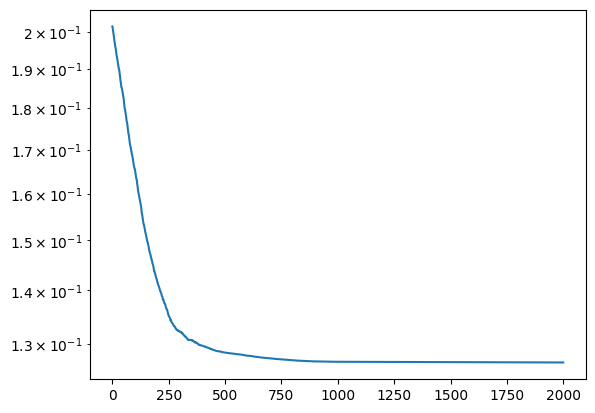

In [57]:
plt.semilogy(history)

In [58]:

# Get training predicted labels
train_pred_labels = logistic_classifier.predict(x_train_normalized, updated_weights, updated_bias)
train_pred_labels = train_pred_labels >= 0.5

train_pred_labels.shape

(233845, 1)

In [40]:

# Get validation predicted labels
# ...

# Get testing predicted labels
test_pred_labels = logistic_classifier.predict(x_test_normalized, updated_weights, updated_bias)
test_pred_labels = test_pred_labels >= 0.5

# Print metrics
metrics_train_df = logistic_classifier.metrics(
    true_labels=y_train,
    pred_labels=train_pred_labels,
    metrics_df=metrics_train_df,
    dataset_label='v' + str(i+1) + ' training'
)
metrics_test_df = logistic_classifier.metrics(
    true_labels=y_test,
    pred_labels=test_pred_labels,
    metrics_df=metrics_test_df,
    dataset_label='v' + str(i+1) + ' testing'
)



/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_28996/172079211.py:170: RuntimeWarning: invalid value encountered in scalar divide
  PR = (TP / (TP + FP)) * 100 # precision


In [38]:
metrics_train_df = None
metrics_test_df = None
for i, dataset in enumerate(datasets):
    # Get dataset (based on the feature vectors defined before)
    input = dataset.to_numpy()

    # Data splitting
    x_train, y_train, _, _, x_test, y_test = data_split(data_input=input, train_size=0.8)

    # SMOTE: oversampling
    n_samples = 6000
    x_minority = x_train[y_train[:, 0] == 1] # minority class samples (attacks)
    x_train_synthetic = fit_resample(x_minority, n_samples=n_samples) # generate synthetic data for training
    y_train_synthetic = np.ones((n_samples,1)) # generate other attack labels as well

    # Add synthetic data to the original one
    x_train_normalized = np.concatenate((x_train, x_train_synthetic), axis=0)
    y_train = np.concatenate((y_train, y_train_synthetic), axis=0)

    # Training set normalisation
    x_train_normalized, data_train_min, data_train_max = min_max(data=x_train_normalized)

    # Validation set normalisation
    # ...

    # Testing set normalisation
    x_test_normalized, _, _ = min_max(x_test, data_train_min, data_train_max)

    # Initialize weights and biases
    weights, bias = logistic_classifier.initialize_parameters(num_features=x_train_normalized.shape[1])

    # Train ann, with gradient descent - mean squared error
    updated_weights, updated_bias, history = logistic_classifier.train(
        x_train = x_train_normalized,
        y_train = y_train,
        weights = weights,
        bias = bias,
        optimizer = logistic_classifier.SGD(
            loss_function=logistic_classifier.cross_entropy(),
            epochs=2000,
            batch_size=256,
            learning_rate_min=1e-3,
            learning_rate_max=1e-1,
            learning_rate_decay=1000
        )
    )

    # Get training predicted labels
    train_pred_labels = logistic_classifier.predict(x_train_normalized, updated_weights, updated_bias)
    train_pred_labels = train_pred_labels >= 0.5

    # Get validation predicted labels
    # ...

    # Get testing predicted labels
    test_pred_labels = logistic_classifier.predict(x_test_normalized, updated_weights, updated_bias)
    test_pred_labels = test_pred_labels >= 0.5

    # Print metrics
    metrics_train_df = logistic_classifier.metrics(
        true_labels=y_train,
        pred_labels=train_pred_labels,
        metrics_df=metrics_train_df,
        dataset_label='v' + str(i+1) + ' training'
    )
    metrics_test_df = logistic_classifier.metrics(
        true_labels=y_test,
        pred_labels=test_pred_labels,
        metrics_df=metrics_test_df,
        dataset_label='v' + str(i+1) + ' testing'
    )

/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_28996/172079211.py:170: RuntimeWarning: invalid value encountered in scalar divide
  PR = (TP / (TP + FP)) * 100 # precision
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_28996/172079211.py:170: RuntimeWarning: invalid value encountered in scalar divide
  PR = (TP / (TP + FP)) * 100 # precision
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_28996/172079211.py:170: RuntimeWarning: invalid value encountered in scalar divide
  PR = (TP / (TP + FP)) * 100 # precision
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_28996/172079211.py:170: RuntimeWarning: invalid value encountered in scalar divide
  PR = (TP / (TP + FP)) * 100 # precision
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_28996/172079211.py:170: RuntimeWarning: invalid value encountered in scalar divide
  PR = (TP / (TP + FP)) * 100 # precision
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_28996/172079211.py:17

In [ ]:
metrics_train_df

In [ ]:
metrics_test_df